# Making Watershed Maps

### Introduction

Watershed maps are generally plotted for study area figures in the manuscripts. These maps show the location of the study area on a map along with data on reservoirs, and others. In this sub-page, we shall focus on plotting basemaps, shapefiles and reservoirs in Python. This page is based on [blog post](https://waterprogramming.wordpress.com/2017/04/03/making-watershed-maps-in-python/) by Julie. The data is used from this [repository](https://github.com/julianneq/RedRiver_RivalFramings/tree/master)

#### Plotting basemap

Plot is shown with the extent of the Red River basin in East Asia. The first step is to create a basemap by specifying the bounding box using the lower and upper latitudes and longitudes of the region. You can specify the resolution (‘f’ = full, ‘h’ =high, ‘i’ = intermediate, ‘l’ = low, ‘c’ = crude), and you can even use different ArcGIS images for the [background](https://basemaptutorial.readthedocs.io/en/latest/backgrounds.html). The example below uses ‘World_Shaded_Relief’. It’s also possible to add a lot of features such as rivers, countries, coastlines, counties, etc. The following example shows countries and rivers. The argument ‘zorder’ specifies the order of the layering from 1 to n, where 1 is the bottom layer and n the top.

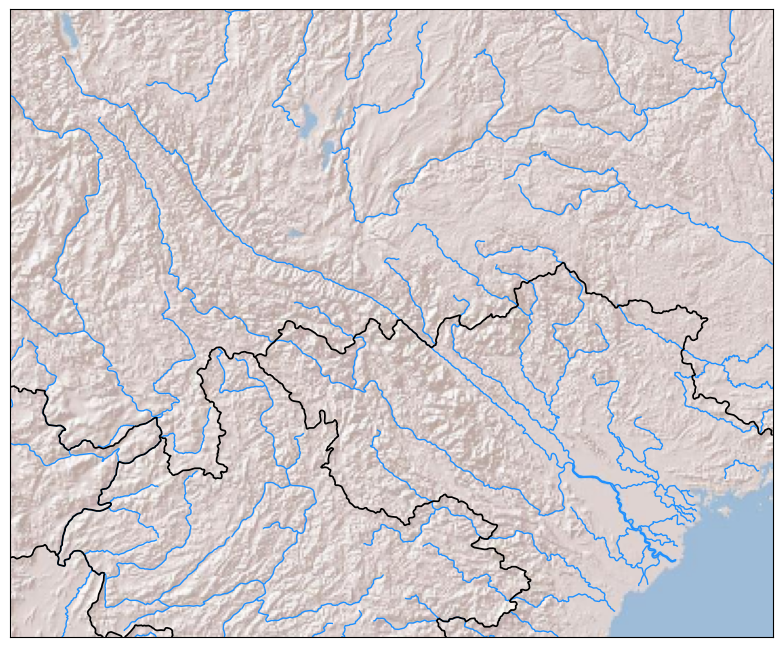

In [126]:
%matplotlib inline
#%pip install basemap-data-hires #installation of basemap
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
import numpy as np

fig = plt.figure()
fig.set_size_inches([17.05,8.15])
ax = fig.add_subplot(111)
 
# plot basemap, rivers and countries
m = Basemap(llcrnrlat=19.5, urcrnrlat=26.0, llcrnrlon=99.6, urcrnrlon=107.5, resolution='h', ax=ax) #specify the extent
m.arcgisimage(service='World_Shaded_Relief')
m.drawrivers(color='dodgerblue',linewidth=1.0,zorder=1)
m.drawcountries(color='k',linewidth=1.25)

Now let’s add a shaded outline of the Red River basin. To do this, you need a shapefile of the basin. The region is shaded in gray (facecolor=’0.33′) with a slightly darker border (edgecolor=’0.5′) and slight transparency (alpha=0.5). To do that, we need to collect all of the patches associated with the shapefile (called as ‘Basin’ when reading it in) that needed to be shaded.

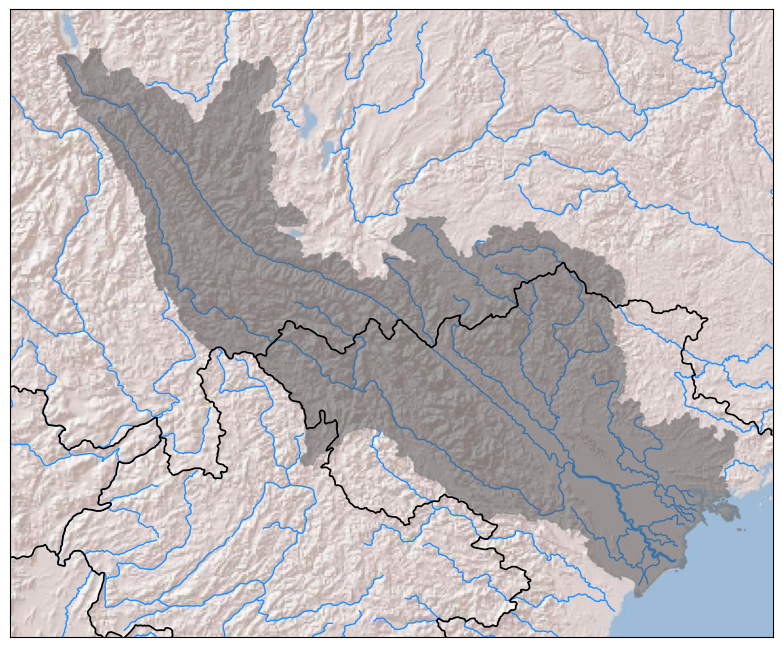

In [127]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
 
# plot Red River basin
m.readshapefile('SupportingFiles/RedRiverBasin_WGS1984', 'Basin', drawbounds=False)#read shapefile
patches = []
for info, shape in zip(m.Basin_info, m.Basin):
    if info['OBJECTID'] == 1: # attribute in attribute table of shapefile
        patches.append(Polygon(np.array(shape), closed=True))
ax.add_collection(PatchCollection(patches, facecolor='0.33', edgecolor='0.5', alpha=0.5)) #add collection to axis
display(fig)

Now let’s add the locations of major dams and cities in the basin using 'scatter'. You could again do this by adding a shapefile, but we are just going to add their locations manually, either by uploading their latitude and longitude coordinates from a .csv file or by passing them directly.

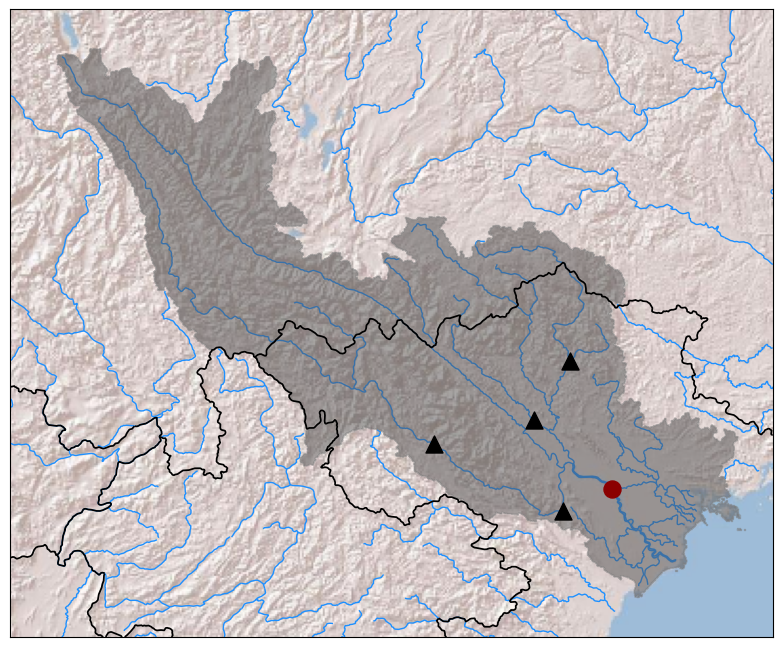

In [128]:
import numpy as np
 
# plot dams
damsLatLong = np.loadtxt('SupportingFiles/DamLocations.csv', delimiter=',', skiprows=1, usecols=[1,2])
x, y = m(damsLatLong[:,1], damsLatLong[:,0]) # m(longitude, latitude)
m.scatter(x, y, c='k', s = 150, marker = '^')
 
# plot Hanoi
x, y = m(105.8342, 21.0278)
m.scatter(x, y, facecolor='darkred', edgecolor='darkred', s=150)
display(fig)

If we want to label the dams and cities, we can add text specifying where on the map we’d like them to be located. This may require some guess-and-check work to determine the best place. One way could be to temporarily add gridlines to the map to aid in this process using 'drawparallels' and 'drawmeridians'.

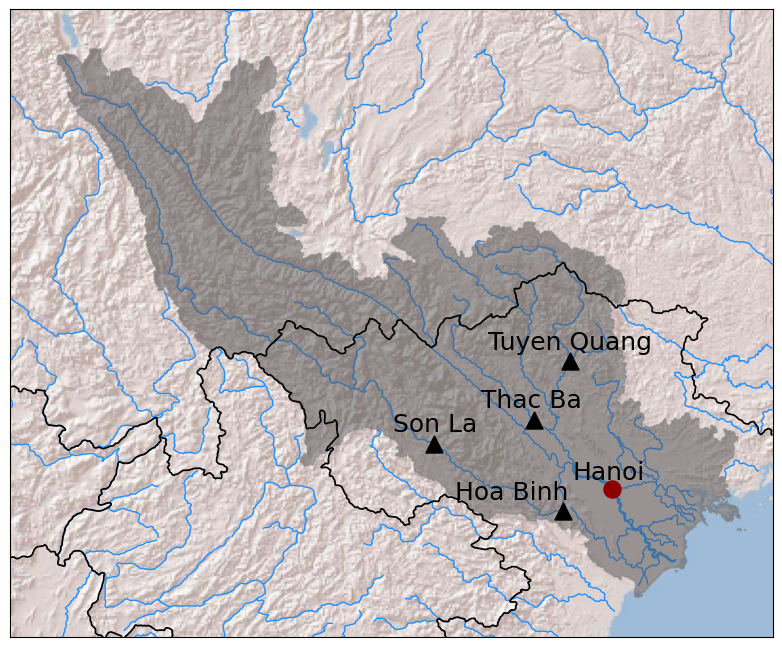

In [129]:
# label dams and Hanoi
ax.text(104.8, 21.0, 'Hoa Binh', fontsize=18, ha='center', va='center', color='k')
ax.text(104.0, 21.7, 'Son La', fontsize=18, ha='center', va='center', color='k')
ax.text(105.0, 21.95, 'Thac Ba', fontsize=18, ha='center', va='center', color='k')
ax.text(105.4, 22.55, 'Tuyen Quang', fontsize=18, ha='center', va='center', color='k')
ax.text(105.8, 21.2, 'Hanoi', fontsize=18, ha='center', va='center', color='k')
display(fig)

That looks nice, but it would be helpful to add some context as to where in the world the Red River basin is located. To illustrate this, we can create an inset of the greater geographical area by adding another set of axes with its own basemap. This one can be at a lower resolution.



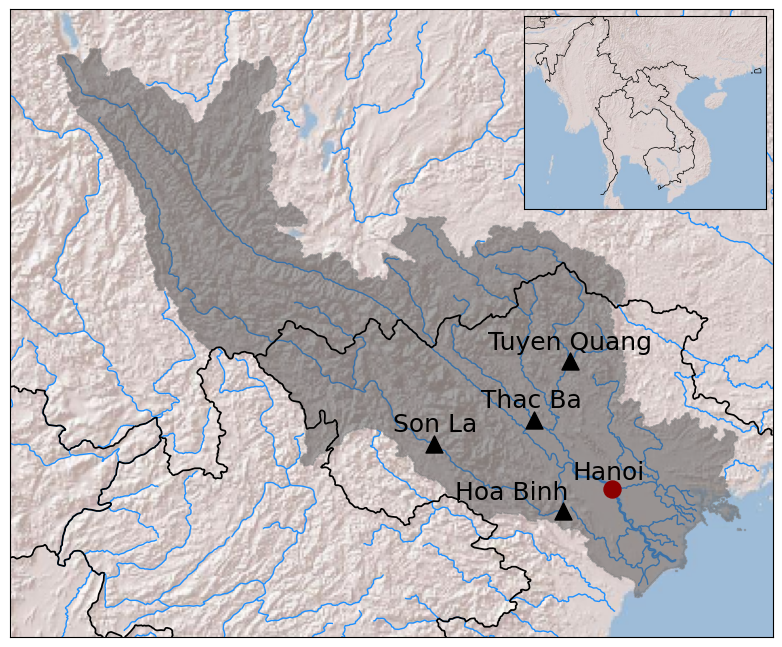

In [130]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
 
# plot inset of greater geographic area
axins = zoomed_inset_axes(ax, 0.1, loc=1) # locations
axins.set_xlim(90, 115) # longitude boundaries of inset map
axins.set_ylim(8, 28) # latitude boundaries of inset map
 
# add basemap to inset map
m2 = Basemap(llcrnrlat=8.0, urcrnrlat=28.0, llcrnrlon=90.0, urcrnrlon=115.0, resolution='l', ax=axins)
m2.arcgisimage(service='World_Shaded_Relief')
m2.drawcountries(color='k', linewidth=0.5)

# remove tick marks from inset axes
axins.set_xticks([])
axins.set_yticks([])
axins.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

display(fig)

Now let’s highlight a country of interest (Vietnam) in green and also add the Red River basin in light gray again.



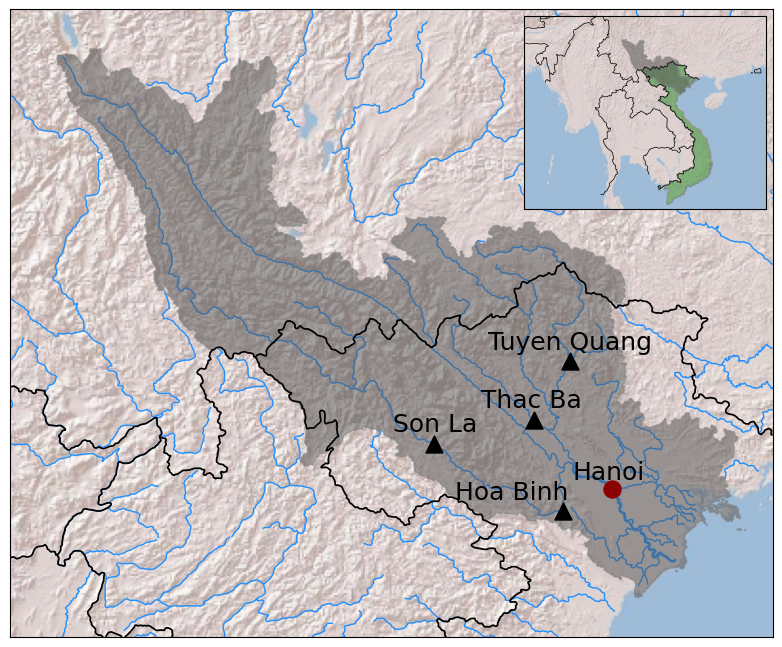

In [131]:
# plot Vietnam green in inset
m2.readshapefile('SupportingFiles/VN_borders_only_WGS1984', 'Vietnam', drawbounds=False)
patches2 = []
for info, shape in zip(m2.Vietnam_info, m2.Vietnam):
    if info['Joiner'] == 1:
        patches2.append(Polygon(np.array(shape), closed=True))
 
axins.add_collection(PatchCollection(patches2, facecolor='forestgreen', edgecolor='0.5', alpha=0.5))

# shade Red River basin gray in inset
axins.add_collection(PatchCollection(patches, facecolor='0.33', edgecolor='0.5', alpha=0.5))
display(fig)

Finally, let’s label the countries in the inset. Some of the countries are too small to fit their name inside, so we’ll have to create arrows pointing to them using ‘annotate‘. In this function, ‘xy’ specifies where the arrow points to and ‘xytext’ where the text is written relative to where the arrow points.



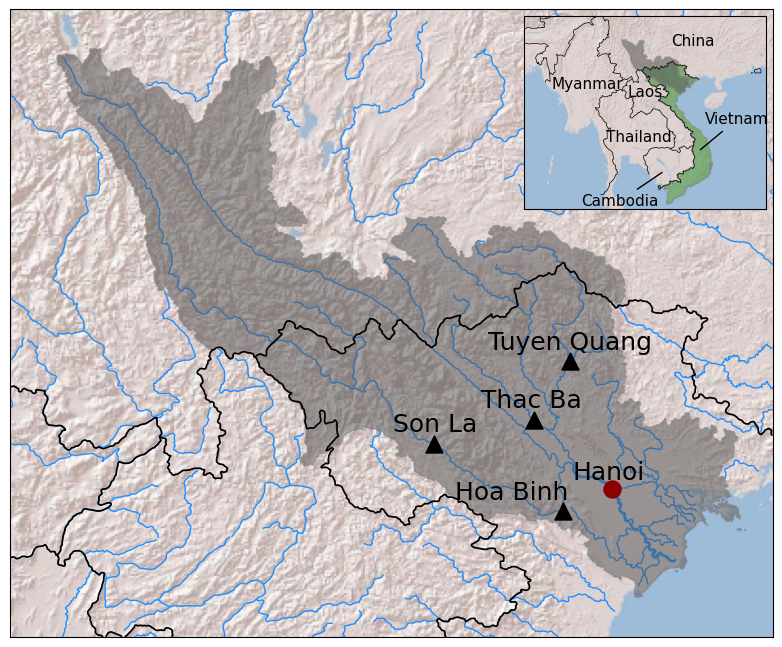

In [132]:
# label countries
axins.text(107.5, 25.5, 'China', fontsize=11, ha='center', va='center', color='k')
axins.text(102.5, 20.2, 'Laos', fontsize=11, ha='center', va='center', color='k')
axins.text(101.9, 15.5, 'Thailand', fontsize=11, ha='center', va='center', color='k')
axins.text(96.5, 21.0, 'Myanmar', fontsize=11, ha='center', va='center', color='k')
 
# add arrows to label Vietnam and Cambodia 
axins.annotate('Vietnam', xy=(108.0, 14.0), xycoords='data', xytext=(5.0, 20.0), textcoords='offset points',color='k', arrowprops=dict(arrowstyle='-'), fontsize=11)
axins.annotate('Cambodia', xy=(104.5, 12.0), xycoords='data', xytext=(-60.0, -25.0), textcoords='offset points',color='k', arrowprops=dict(arrowstyle='-'), fontsize=11)
display(fig)